## Data Cleaning

In [99]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", None)

In [100]:
# define column names as defined by the NASA instructions

def load_cmapss_data(train_path, test_path, rul_path):

    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']

    # there are three operational settings that are utilized by the engine
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]

    # join the index, setting and sensor column names to then apply to the txt files
    col_names = index_names + setting_names + sensor_names

    # read txt data and apply the above
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])

    return train, test, y_test

In [101]:
def load_cmapss_data(train_path, test_path, rul_path, include_sensor_desc = True):

    # sensor column descriptions
    description_headers = ["Temp, fan in", "Temp, LPC out", "Temp, HPC out", 
                           "Temp, LPT out", "Press, fan in", "Tot Press, bypass", "Tot Press, HPC out",
                           "Speed, fan", "Speed, core", "Eng Press Ratio", "Stat Press, HPC out", 
                           "phi Fuel Flow Ratio", "Corr. Speed, Fan", "Corr. Speed, Core", "Bypass Ratio", 
                           "Burner Fuel/Air Ratio", "Bleed Enthalpy", "Dem Speed, fan", "Dem Corr Speed, fan", 
                           "Coolant Bleed, HPT", "Coolant Bleed, LPT" ]
    
    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']
    
    # there are three operational settings that are utilized by the engine 
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
    
    # join the index, setting and sensor column names to then apply to the txt files
    if include_sensor_desc == False:
        col_names = index_names + setting_names + sensor_names
    else:
        col_names = index_names + setting_names + description_headers
    
    # read txt data and apply the above 
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])
    
    return train, test, y_test

In [102]:
# Data Set: FD001
# Train trjectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# reading in the first dataset since it is a dataset that has one condition and one fault, and will allow us to make a relatively easier model
# that can then be built upon in complexity in the second stage of the analysis

train, test, y_test = load_cmapss_data('../data/CMAPSSData/train_FD001.txt', '../data/CMAPSSData/test_FD001.txt', '../data/CMAPSSData/RUL_FD001.txt', False)

In [103]:
original_cols = train.columns
original_cols

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'],
      dtype='object')

In [104]:
train.head()

unit_number  time_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1            1    -0.0007    -0.0004      100.0    518.67   
1            1            2     0.0019    -0.0003      100.0    518.67   
2            1            3    -0.0043     0.0003      100.0    518.67   
3            1            4     0.0007     0.0000      100.0    518.67   
4            1            5    -0.0019    -0.0002      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392       2388      100.0   
1    8131.49     8.4318       0.03        392       2388      100.0   
2    8133.23     8.4178       0.03        390       2388      100.0   
3    8133.83     8.3682       0.03        392       2388      100.0   
4    8133.80     8.4294       0.03        393       2388      100.0   

   sensor_20  sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  
2      38.95    23.3442  
3      38.88    23.3739  
4      38.90    23.4044  

[5 rows x 26 columns]

In [105]:
# to get the number of unique engines in the dataset we can look at the number of unique numbers in the first column
len(np.unique(train["unit_number"]))

100

In [106]:
# the number of cycles it took for each of these engines to fail
num_cycles_to_failure = train.groupby("unit_number")["time_cycles"].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200], dtype=int64)

In [107]:
train.describe()

unit_number   time_cycles     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568    108.807862     -0.000009      0.000002      100.0   
std       29.227633     68.880990      0.002187      0.000293        0.0   
min        1.000000      1.000000     -0.008700     -0.000600      100.0   
25%       26.000000     52.000000     -0.001500     -0.000200      100.0   
50%       52.000000    104.000000      0.000000      0.000000      100.0   
75%       77.000000    156.000000      0.001500      0.000300      100.0   
max      100.000000    362.000000      0.008700      0.000600      100.0   

       sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01  ...   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01  ...   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01  ...   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01  ...   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01  ...   

          sensor_12     sensor_13     sensor_14     sensor_15     sensor_16  \
count  20631.000000  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean     521.413470   2388.096152   8143.752722      8.442146  3.000000e-02   
std        0.737553      0.071919     19.076176      0.037505  1.387812e-17   
min      518.690000   2387.880000   8099.940000      8.324900  3.000000e-02   
25%      520.960000   2388.040000   8133.245000      8.414900  3.000000e-02   
50%      521.480000   2388.090000   8140.540000      8.438900  3.000000e-02   
75%      521.950000   2388.140000   8148.310000      8.465600  3.000000e-02   
max      523.380000   2388.560000   8293.720000      8.584800  3.000000e-02   

          sensor_17  sensor_18  sensor_19     sensor_20     sensor_21  
count  20631.000000    20631.0    20631.0  20631.000000  20631.000000  
mean     393.210654     2388.0      100.0     38.816271     23.289705  
std        1.548763        0.0        0.0      0.180746      0.108251  
min      388.000000     2388.0      100.0     38.140000     22.894200  
25%      392.000000     2388.0      100.0     38.700000     23.221800  
50%      393.000000     2388.0      100.0     38.830000     23.297900  
75%      394.000000     2388.0      100.0     38.950000     23.366800  
max      400.000000     2388.0      100.0     39.430000     23.618400  

[8 rows x 26 columns]

In [108]:
def drop_constant_value(df):
    # identify the columns where the value is constant throughout (hence obsolete)
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]

    # drop them
    return df.drop(columns=constant_columns)

# drop them in the train
train = drop_constant_value(train)

# check the shape of the train dataset
train.shape


(20631, 19)

In [127]:
def add_remaining_useful_life(df):
    # get the max cycle for each unit (100 units)
    max_cycle = df.groupby("unit_number")["time_cycles"].transform('max')

    # compute the RUL for each unit row by row till it hits 0
    df["RUL"] = max_cycle - df["time_cycles"]

    return df

# apply function
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)

train.tail()

unit_number  time_cycles  sensor_2  sensor_3  sensor_4  sensor_6  \
20626          100          196    643.49   1597.98   1428.63     21.61   
20627          100          197    643.54   1604.50   1433.58     21.61   
20628          100          198    643.42   1602.46   1428.18     21.61   
20629          100          199    643.23   1605.26   1426.53     21.61   
20630          100          200    643.85   1600.38   1432.14     21.61   

       sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  \
20626    551.43   2388.19   9065.52      48.07     519.49    2388.26   
20627    550.86   2388.23   9065.11      48.04     519.68    2388.22   
20628    550.94   2388.24   9065.90      48.09     520.01    2388.24   
20629    550.68   2388.25   9073.72      48.39     519.67    2388.23   
20630    550.79   2388.26   9061.48      48.20     519.30    2388.26   

       sensor_15  sensor_17  sensor_20  sensor_21  RUL  
20626     8.4956        397      38.49    22.9735    4  
20627     8.5139        395      38.30    23.1594    3  
20628     8.5646        398      38.44    22.9333    2  
20629     8.5389        395      38.29    23.0640    1  
20630     8.5036        396      38.37    23.0522    0

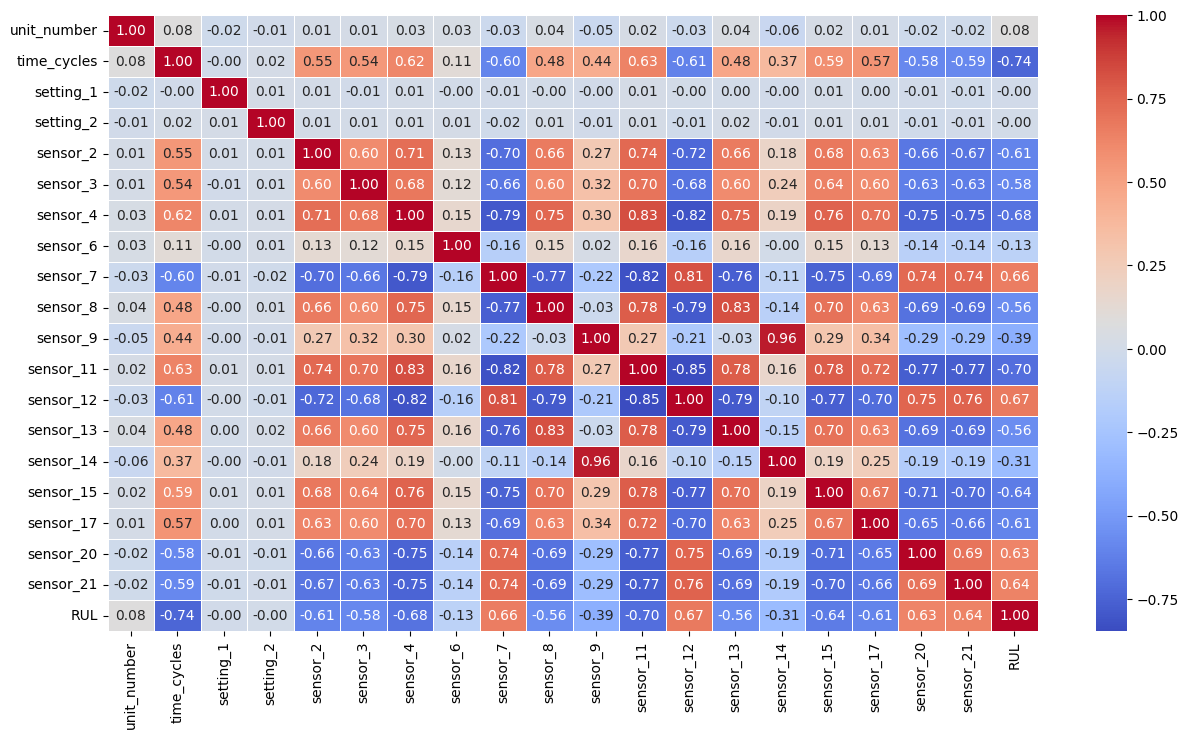

In [110]:
# make corr matrix
corr_matrix = train.corr()

# plot heatmap for corr matrix
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.show()



In [111]:
def drop_highly_correlated_features(df, threshold=0.95):

    # get the absolute corr matrix
    corr_matrix = df.corr().abs()

    # iterate through each col and find the one with the highest correlations
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[i]
                to_drop.add(colname)

    # drop the col that has highest correlations
    df = df.drop(columns=to_drop)

    print(to_drop)

    return df

# call function
train = drop_highly_correlated_features(train)


{'sensor_14'}


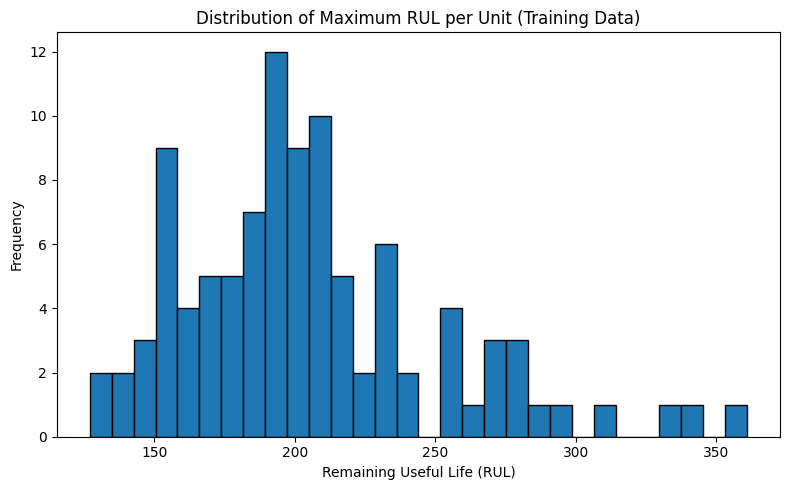

In [130]:
# get the maximum RUL for each unit
df_max_rul = train.groupby('unit_number')['RUL'].max().reset_index()

# plot historgram
plt.figure(figsize=(8, 5))
plt.hist(df_max_rul['RUL'], bins=30, edgecolor='black')

# labels and title
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum RUL per Unit (Training Data)')

plt.tight_layout()
plt.show()


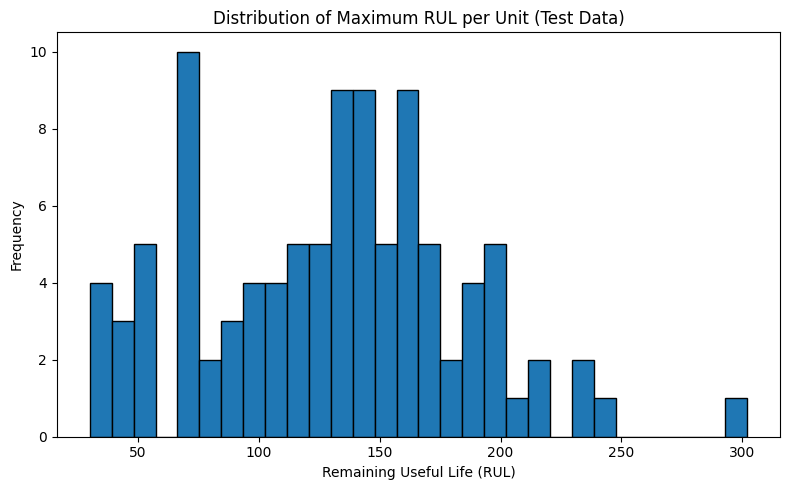

In [131]:
# get the maximum RUL for each unit
df_max_rul = test.groupby('unit_number')['RUL'].max().reset_index()

# plot historgram
plt.figure(figsize=(8, 5))
plt.hist(df_max_rul['RUL'], bins=30, edgecolor='black')

# labels and title
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum RUL per Unit (Test Data)')

plt.tight_layout()
plt.show()

In [113]:
train.head()

unit_number  time_cycles  setting_1  setting_2  sensor_2  sensor_3  \
0            1            1    -0.0007    -0.0004    641.82   1589.70   
1            1            2     0.0019    -0.0003    642.15   1591.82   
2            1            3    -0.0043     0.0003    642.35   1587.99   
3            1            4     0.0007     0.0000    642.35   1582.79   
4            1            5    -0.0019    -0.0002    642.37   1582.85   

   sensor_4  sensor_6  sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  \
0   1400.60     21.61    554.36   2388.06   9046.19      47.47     521.66   
1   1403.14     21.61    553.75   2388.04   9044.07      47.49     522.28   
2   1404.20     21.61    554.26   2388.08   9052.94      47.27     522.42   
3   1401.87     21.61    554.45   2388.11   9049.48      47.13     522.86   
4   1406.22     21.61    554.00   2388.06   9055.15      47.28     522.19   

   sensor_13  sensor_15  sensor_17  sensor_20  sensor_21  RUL  
0    2388.02     8.4195        392      39.06    23.4190  191  
1    2388.07     8.4318        392      39.00    23.4236  190  
2    2388.03     8.4178        390      38.95    23.3442  189  
3    2388.08     8.3682        392      38.88    23.3739  188  
4    2388.04     8.4294        393      38.90    23.4044  187

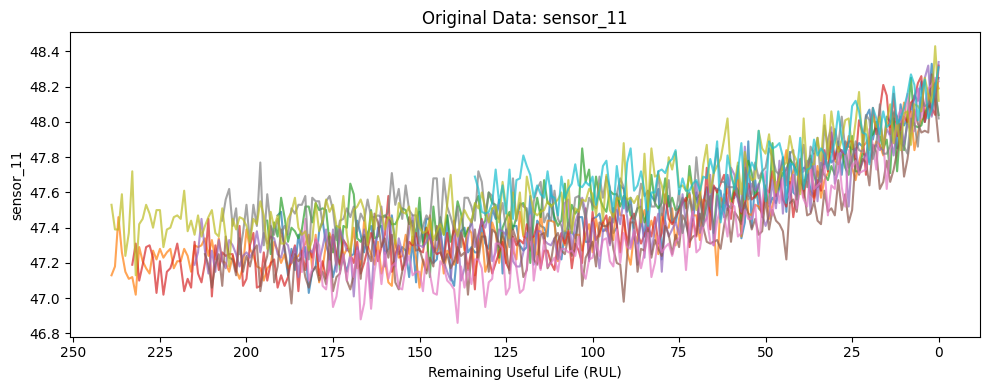

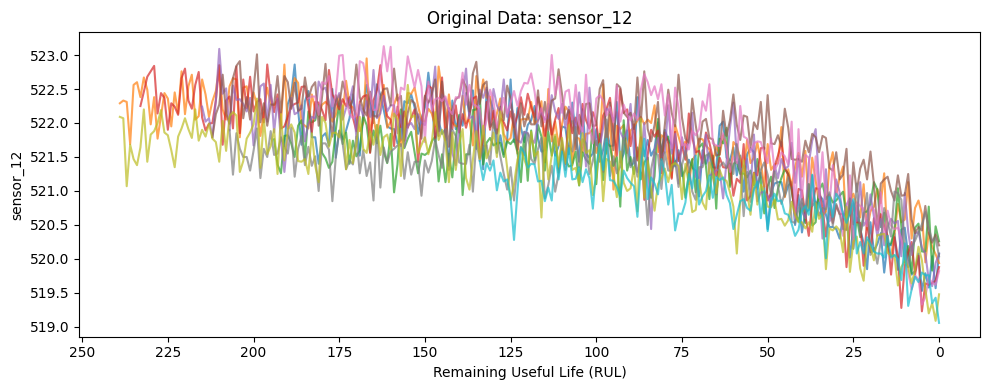

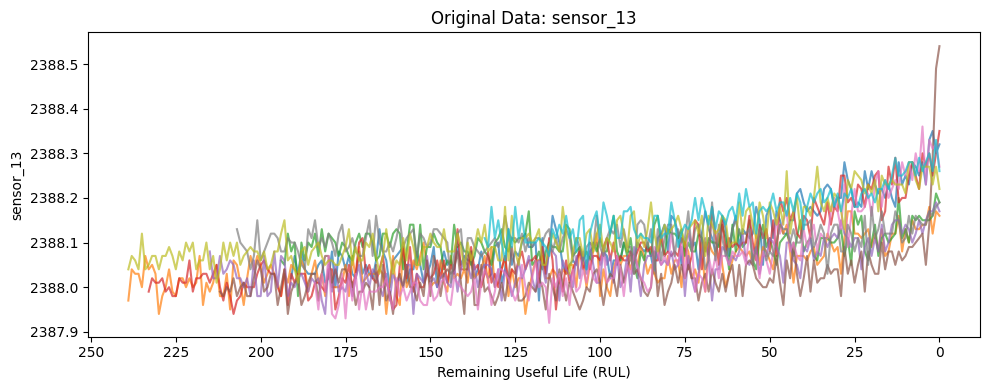

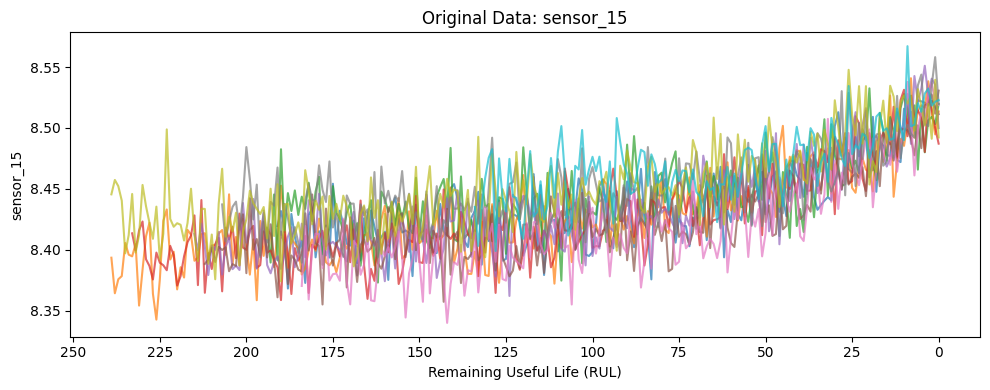

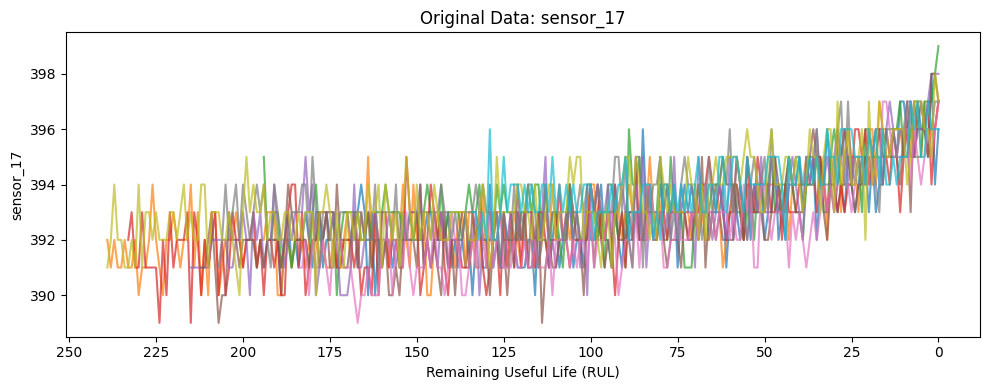

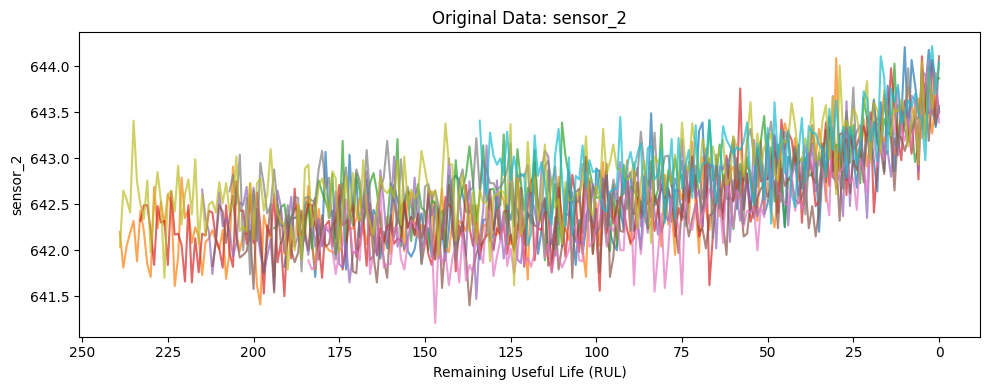

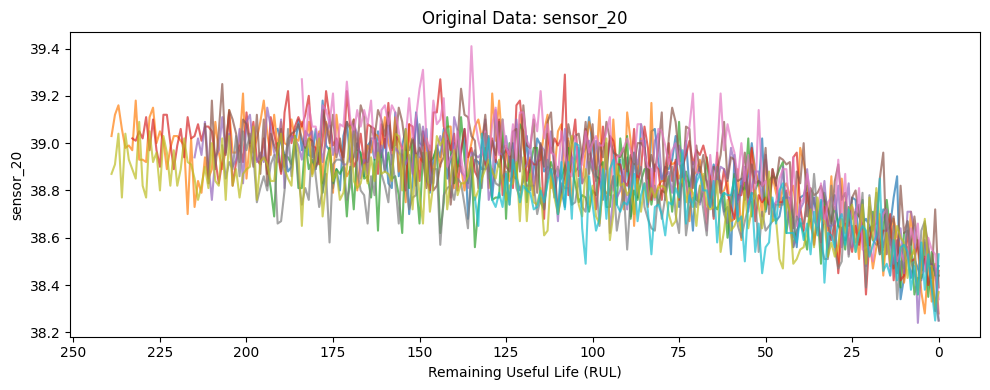

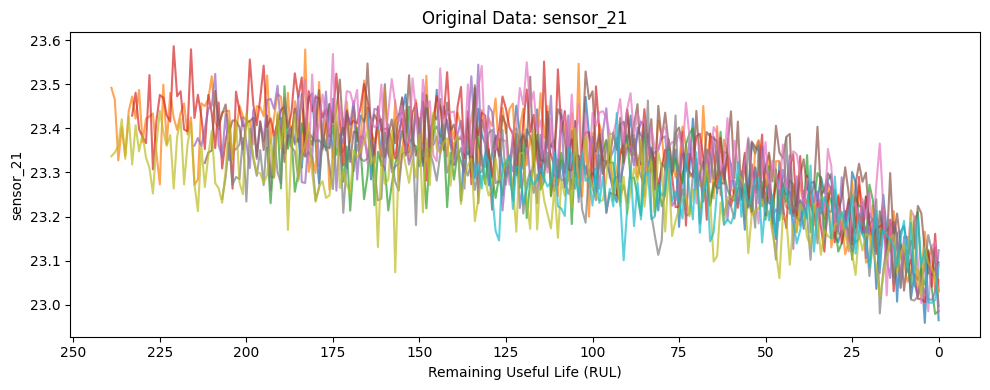

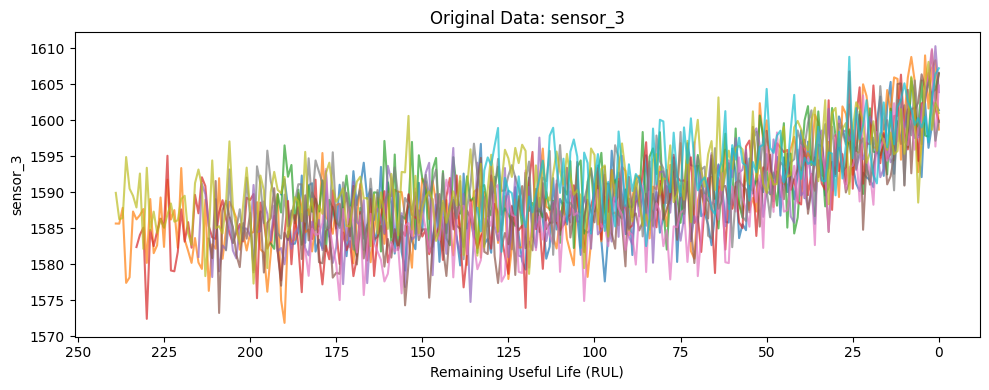

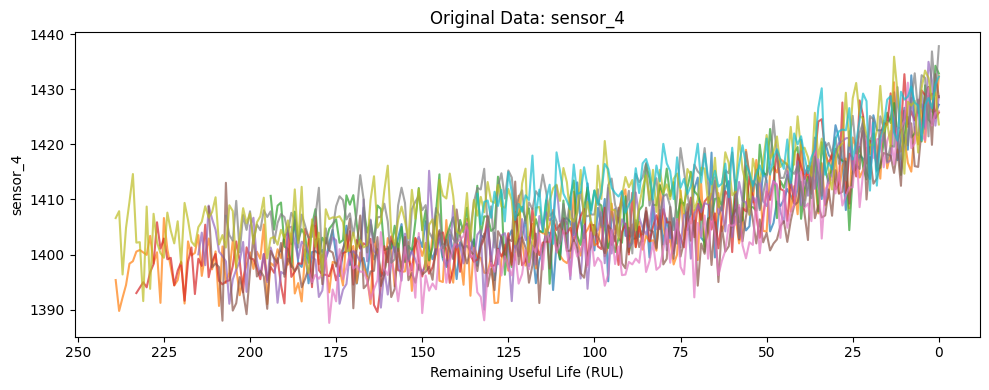

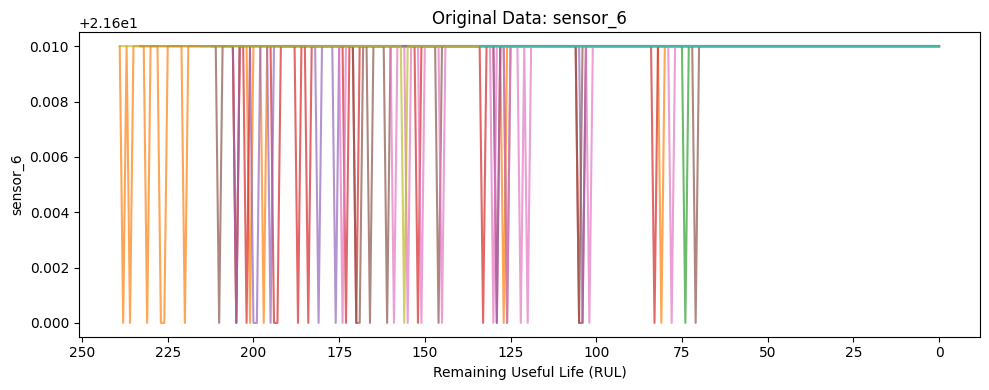

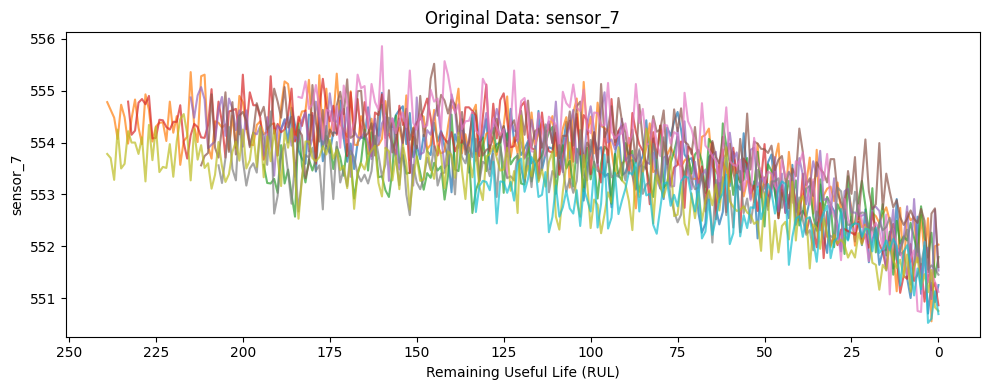

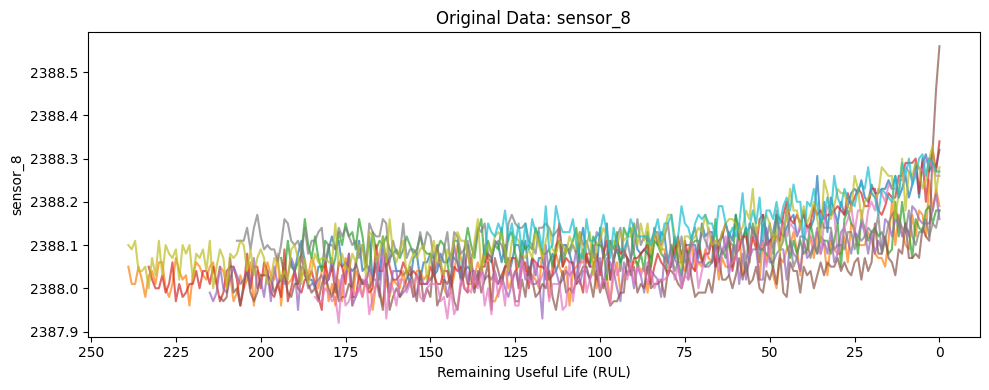

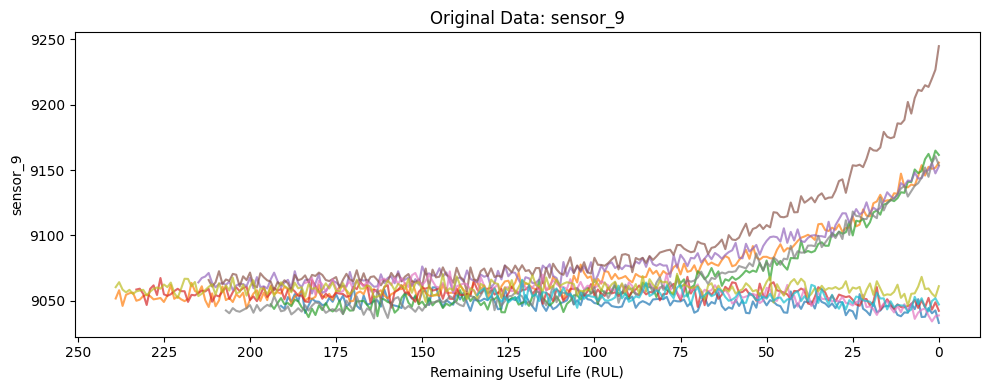

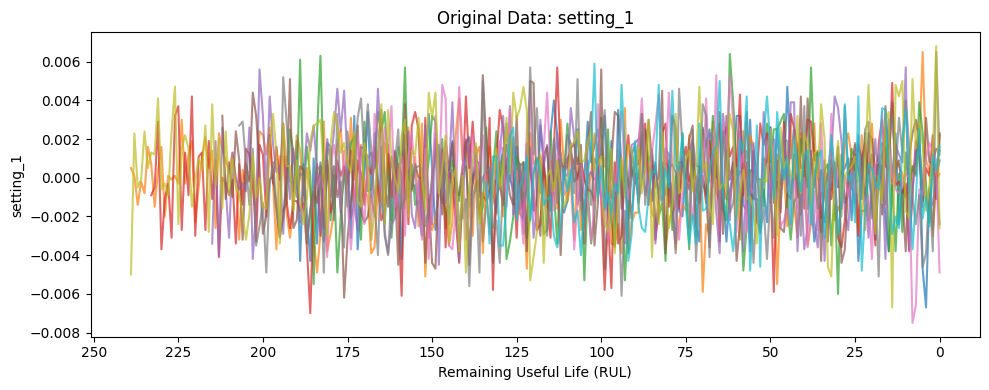

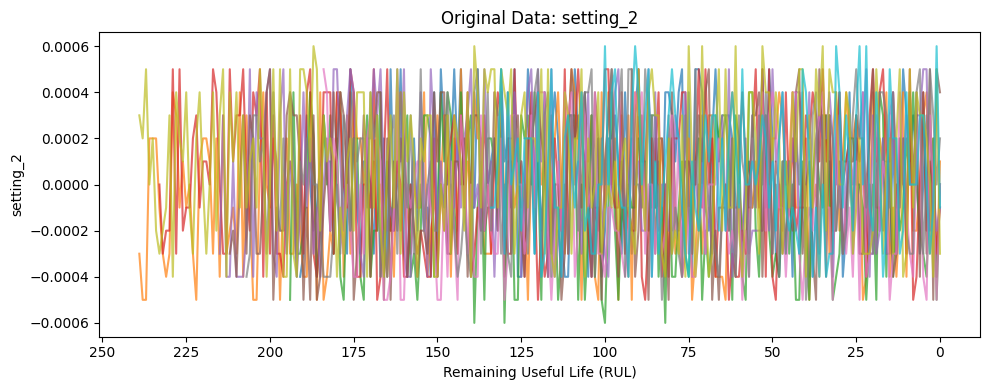

In [114]:
# plot the sensors individually against the RUL
def plot_sensors(train, step=10, plot_type="Data"):

    # find the sensor cols all which have a number in them and excluse unit_number and rul
    sensor_cols = train.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    for sensor in sensor_cols:
        plt.figure(figsize=(10, 4))

        # plot for every nth unit (10th, 20th, 30th ... etc)
        for unit in train['unit_number'].unique()[::step]:
            plt.plot(train[train['unit_number'] == unit]['RUL'],
                     train[train['unit_number'] == unit][sensor],
                     label=f'Unit {unit}', alpha=0.7)

        plt.gca().invert_xaxis()  # reverse the x axis so that RUL is decreasing
        plt.xticks(np.arange(0, 275, 25))
        plt.ylabel(sensor)
        plt.xlabel('Remaining Useful Life (RUL)')
        plt.title(f'{plot_type}: {sensor}')
        plt.tight_layout()
        plt.show()

# Call the function to plot all sensors
plot_sensors(train,plot_type="Original Data")


In [115]:
# we see that there are some settings/sensors that do not have much patterns when mapped against RUL. let's find them.

def drop_low_correlation_features(df, target_column='RUL', threshold=0.1, exclude_columns=None):

    # exclude specified columns
    if exclude_columns is None:
        exclude_columns = []

    # get corr matrix
    corr_matrix = df.drop(columns=exclude_columns).corr()

    # get corr matrix against target col
    correlations = corr_matrix[target_column]

    # get features with correlations lower than the threshold
    low_correlation_features = correlations[correlations.abs() < threshold].index.tolist()

    # drop those with less than the threshold correlations
    df = df.drop(columns=low_correlation_features)

    return df

train = drop_low_correlation_features(train, threshold=0.1, exclude_columns=['unit_number', 'time_cycles'])

train.head()

unit_number  time_cycles  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  \
0            1            1    641.82   1589.70   1400.60     21.61    554.36   
1            1            2    642.15   1591.82   1403.14     21.61    553.75   
2            1            3    642.35   1587.99   1404.20     21.61    554.26   
3            1            4    642.35   1582.79   1401.87     21.61    554.45   
4            1            5    642.37   1582.85   1406.22     21.61    554.00   

   sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  sensor_15  sensor_17  \
0   2388.06   9046.19      47.47     521.66    2388.02     8.4195        392   
1   2388.04   9044.07      47.49     522.28    2388.07     8.4318        392   
2   2388.08   9052.94      47.27     522.42    2388.03     8.4178        390   
3   2388.11   9049.48      47.13     522.86    2388.08     8.3682        392   
4   2388.06   9055.15      47.28     522.19    2388.04     8.4294        393   

   sensor_20  sensor_21  RUL  
0      39.06    23.4190  191  
1      39.00    23.4236  190  
2      38.95    23.3442  189  
3      38.88    23.3739  188  
4      38.90    23.4044  187

In [116]:
test.shape

(13096, 26)

In [117]:
test = test[train.columns.intersection(test.columns)]
test.shape

(13096, 16)

In [118]:
reduced_cols = [col for col in train.columns if col != 'RUL']


In [119]:
# identify the columns which were omitted through cleaning and their indices
missing_indices = []

for index, column in enumerate(original_cols):
    if column not in reduced_cols:
        missing_indices.append(index)

print("ommitted indices:", missing_indices)
print("ommitted columns:", [original_cols[i] for i in missing_indices])


ommitted indices: [2, 3, 4, 5, 9, 14, 18, 20, 22, 23]
ommitted columns: ['setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_14', 'sensor_16', 'sensor_18', 'sensor_19']


In [120]:
# save missing_indices to a .npy file
np.save('missing_indices.npy', np.array(missing_indices))


## SuperSmoother

Experimenting with smoothers to apply to the df to reduce noise.

In [121]:
from supersmoother import SuperSmoother

def supersmooth_train(df):
    # create df to store variables 
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    smoothed_df['RUL'] = df['RUL']
    
    sensor_cols = df.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    # apply smoother
    for sensor in sensor_cols:
        smoother = SuperSmoother()
        smoother.fit(df['time_cycles'], df[sensor])
        smoothed_df[sensor] = smoother.predict(df['time_cycles'])

    return smoothed_df

# apply to train data
smoothed_df_train = supersmooth_train(train)

In [122]:
def supersmooth_test(df):
    # create df to store variables 
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    
    sensor_cols = df.columns.difference(['unit_number', 'time_cycles'])

    # apply smoother
    for sensor in sensor_cols:
        smoother = SuperSmoother()
        smoother.fit(df['time_cycles'], df[sensor])
        smoothed_df[sensor] = smoother.predict(df['time_cycles'])

    return smoothed_df

# apply to test data
smoothed_df_test = supersmooth_test(test)

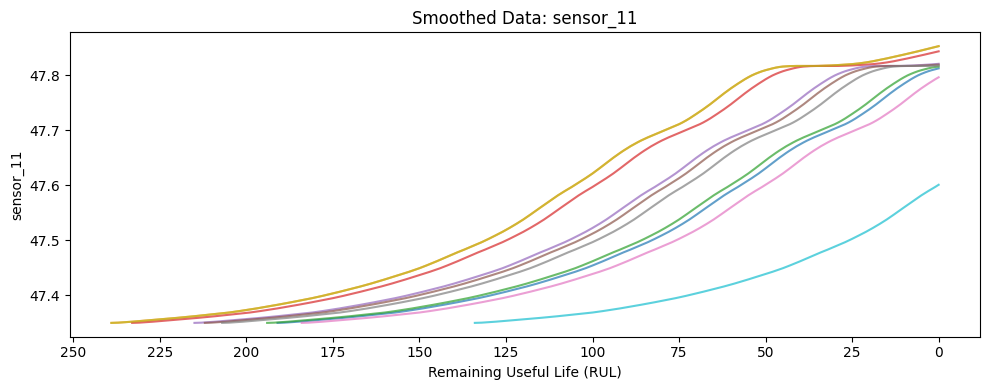

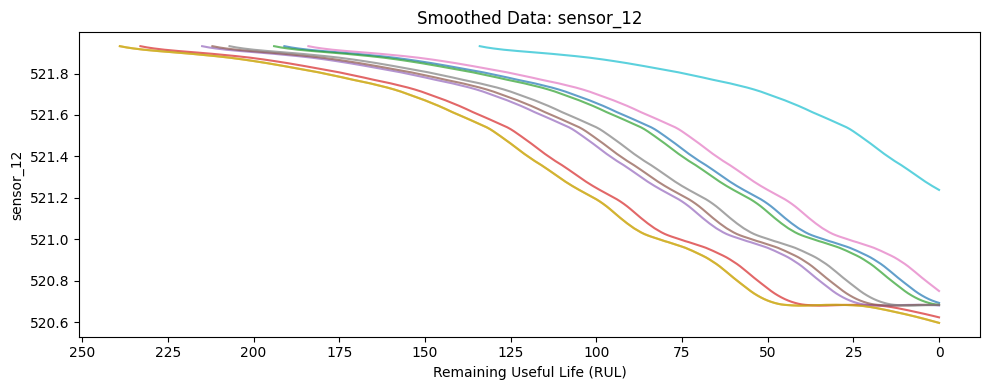

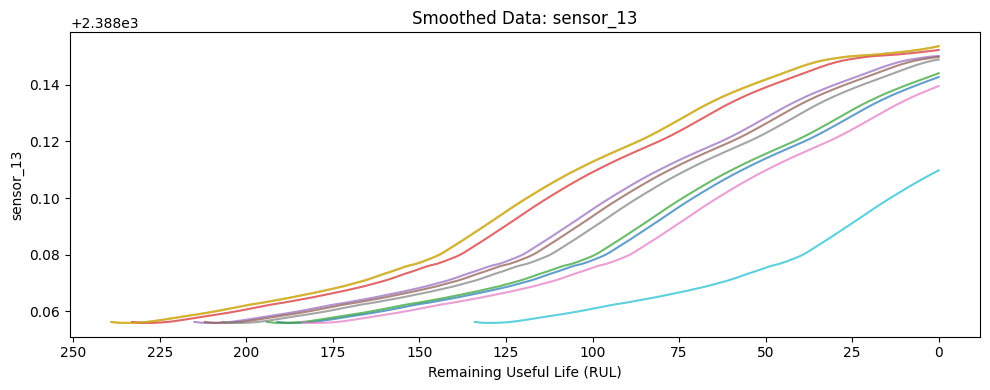

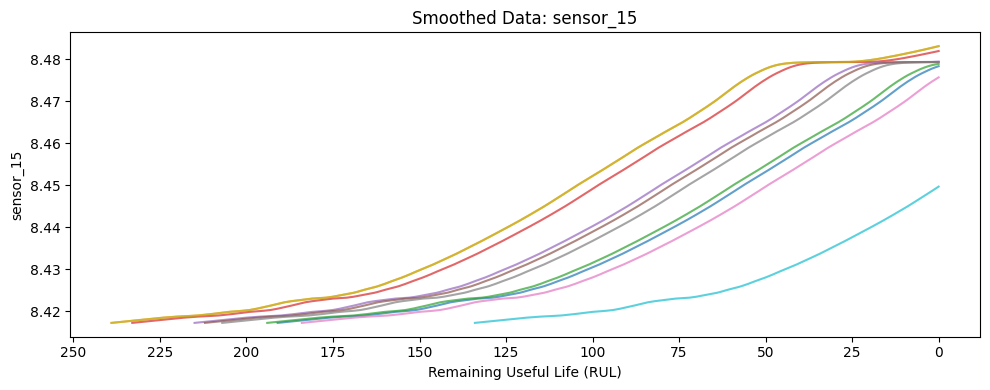

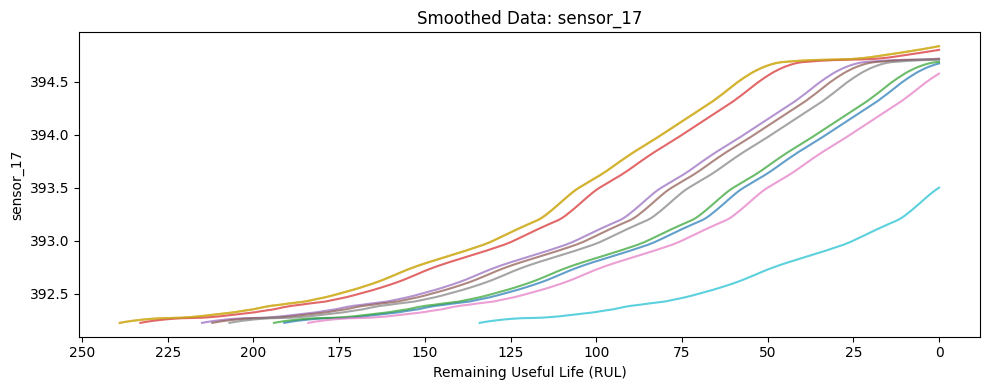

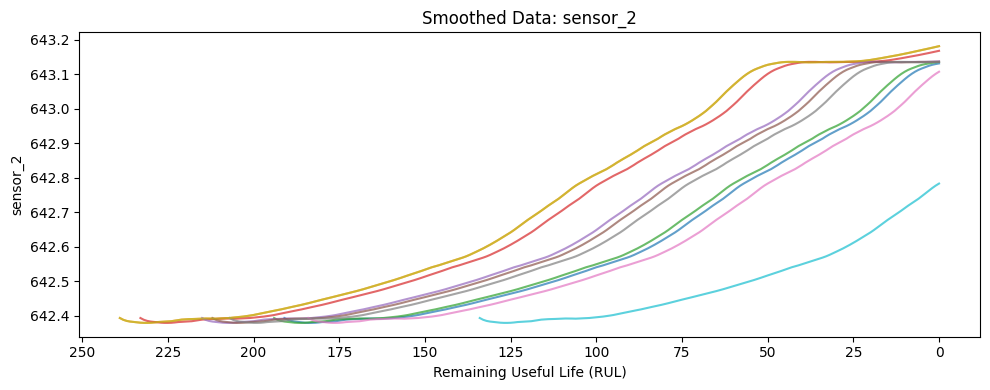

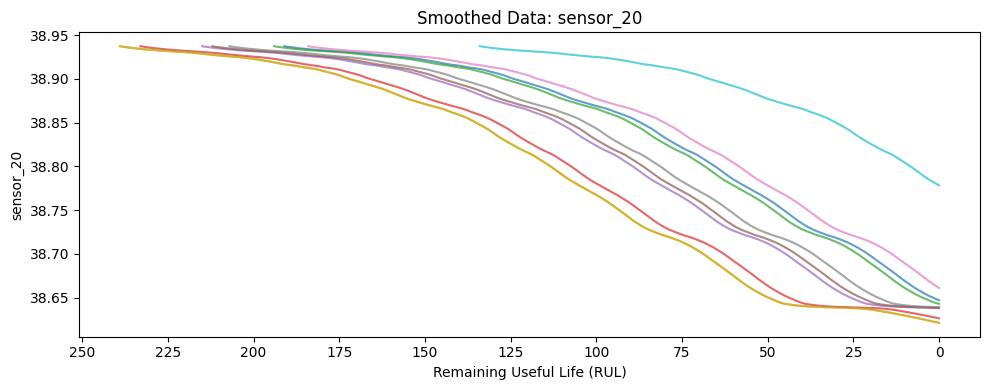

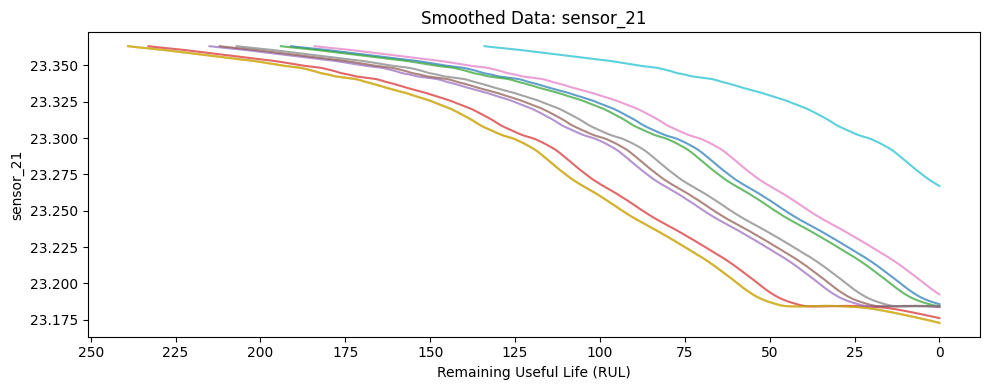

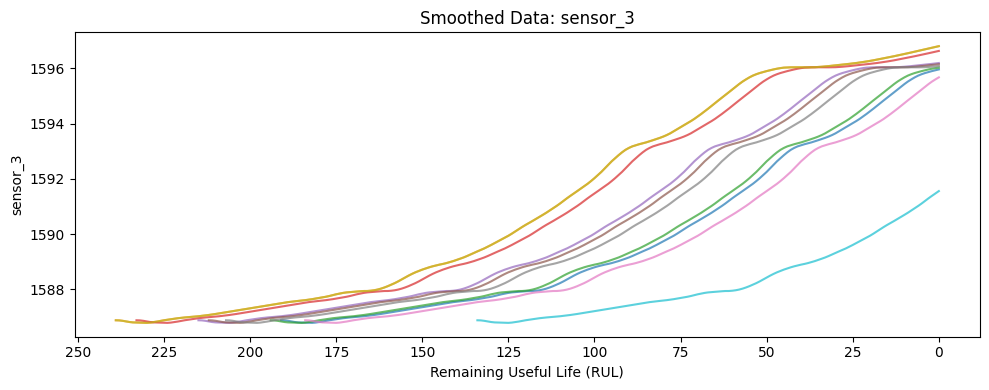

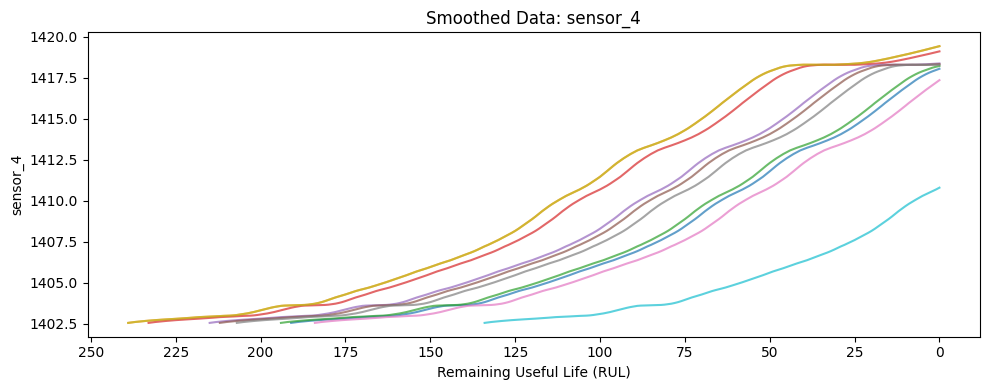

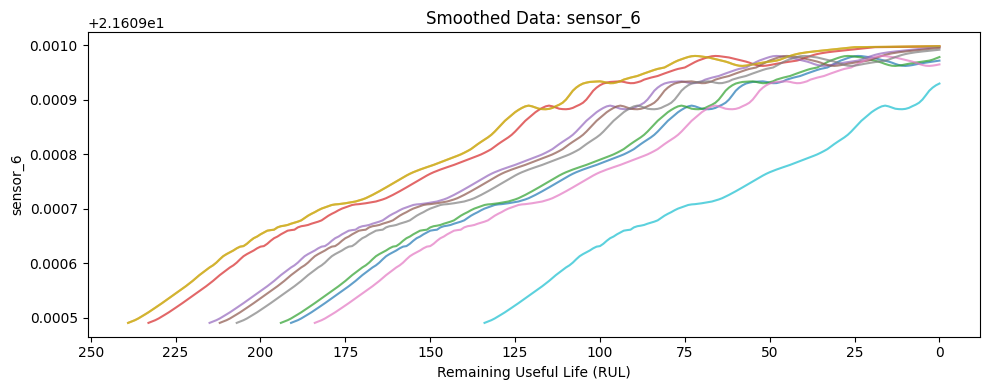

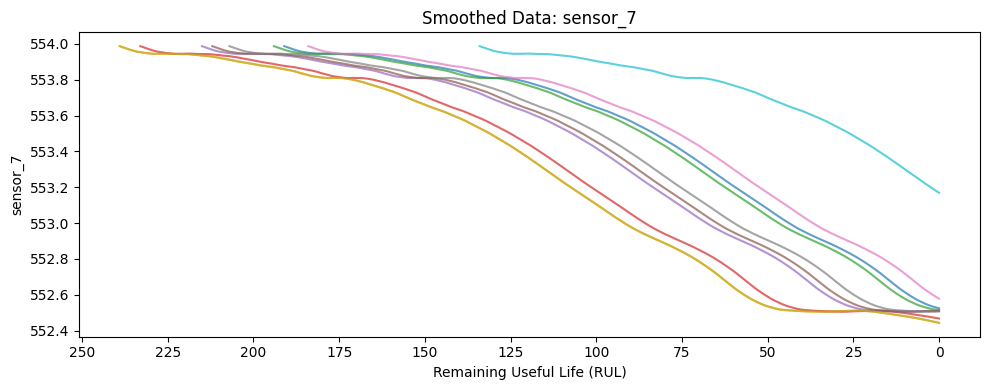

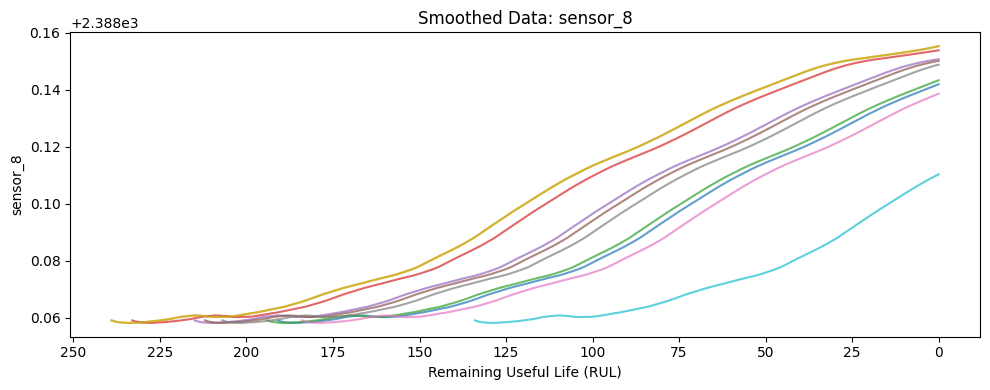

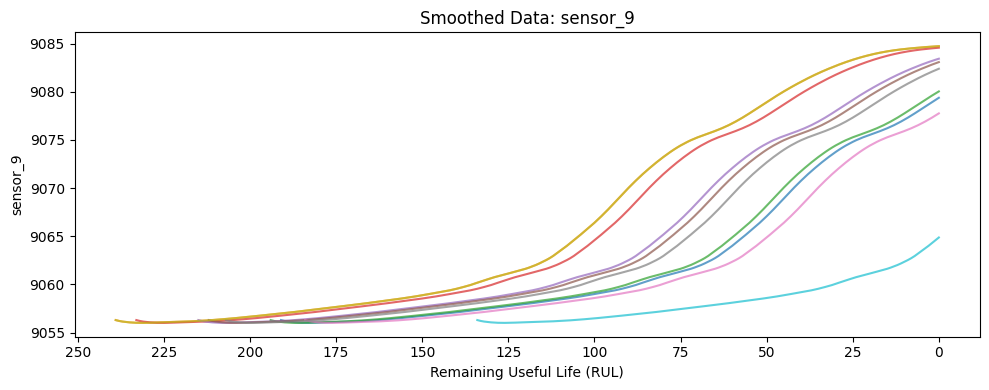

In [123]:
plot_sensors(smoothed_df_train, plot_type="Smoothed Data")

## Exponential Smoothing

In [124]:
def exp_smooth(df, alpha=0.5):
    # create a new df to store the smoothed values
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    smoothed_df['RUL'] = df['RUL']

    sensor_cols = df.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    # apply exp smoother to each sensor column
    for sensor in sensor_cols:
        smoothed_df[sensor] = df[sensor].ewm(alpha=alpha).mean()

    # return the smoothed smoothed df
    return smoothed_df

# apply to df
smoothed_df = exp_smooth(train, 0.5)

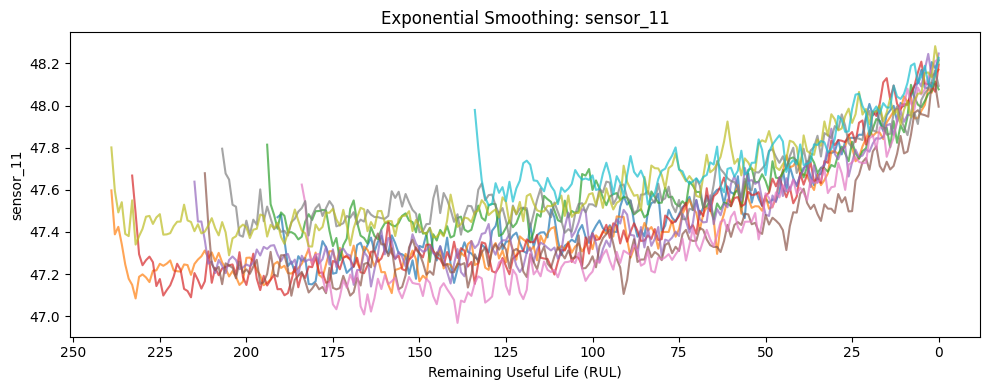

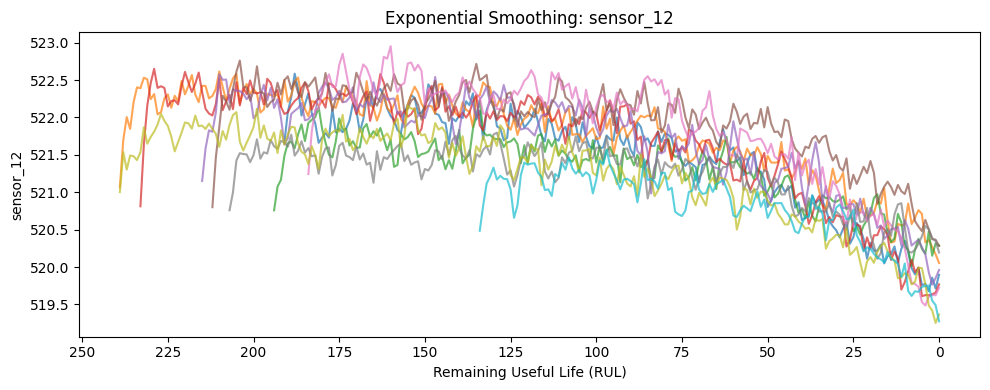

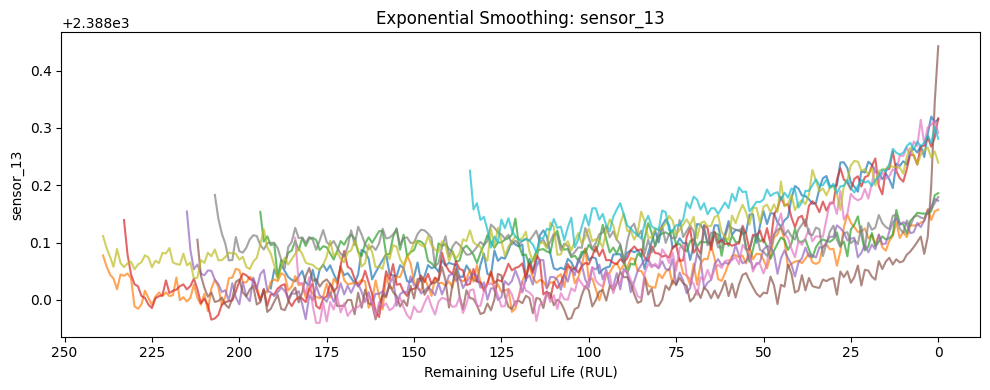

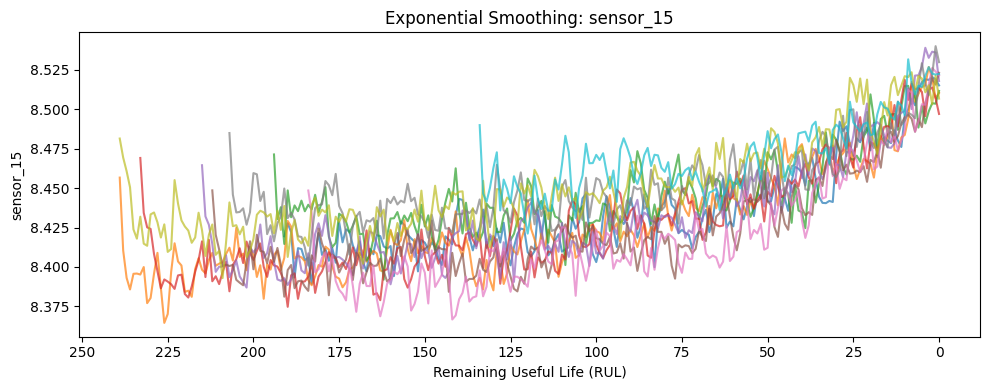

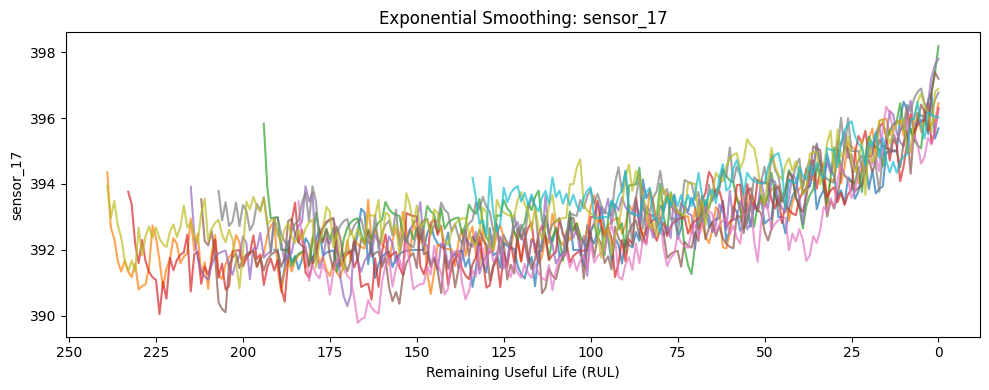

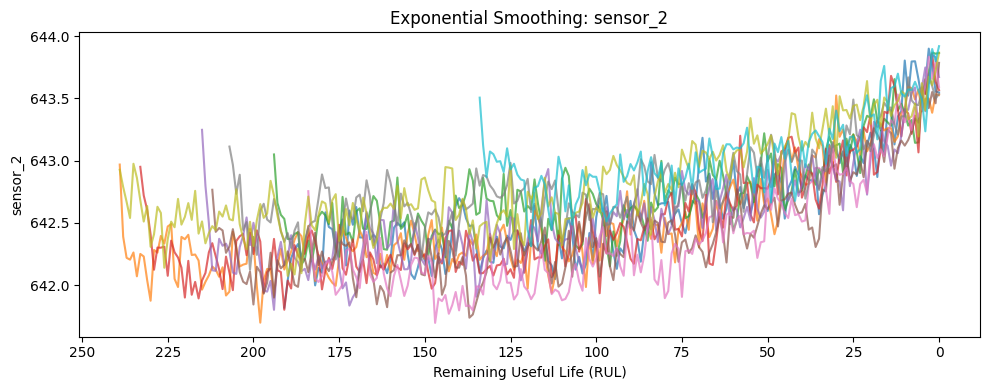

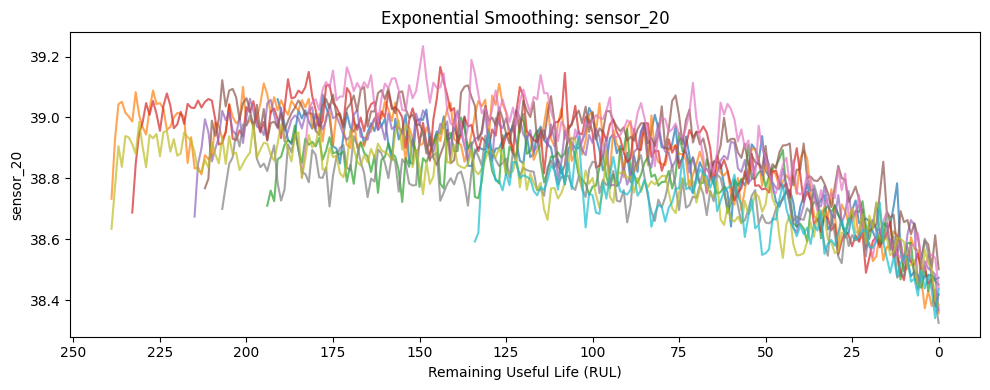

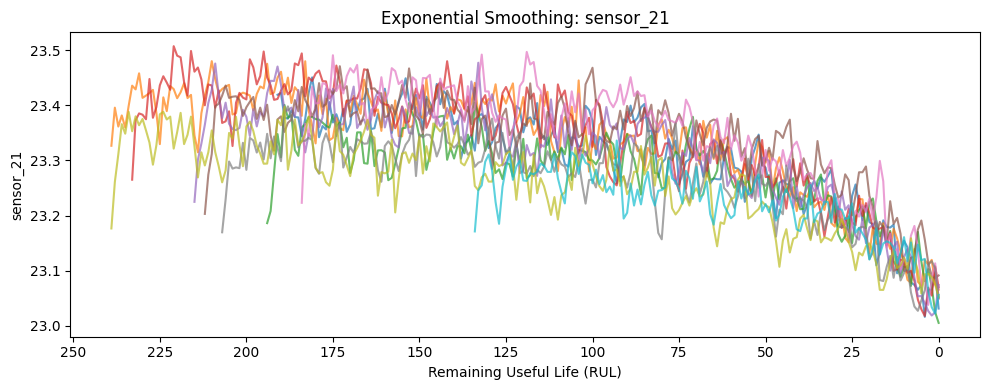

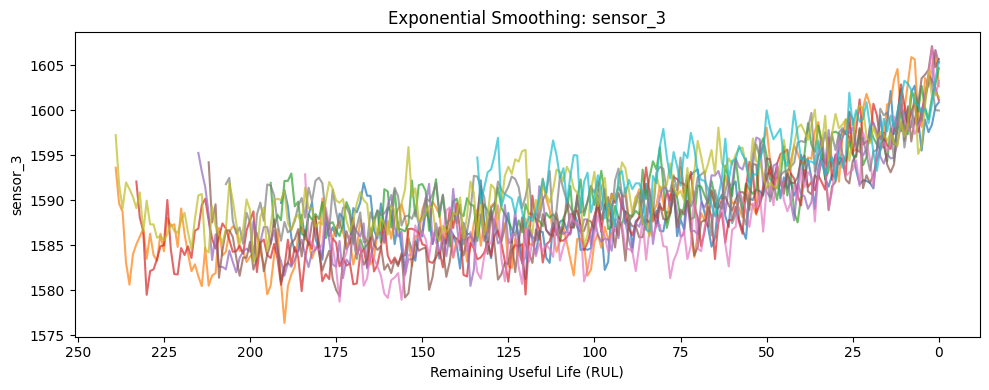

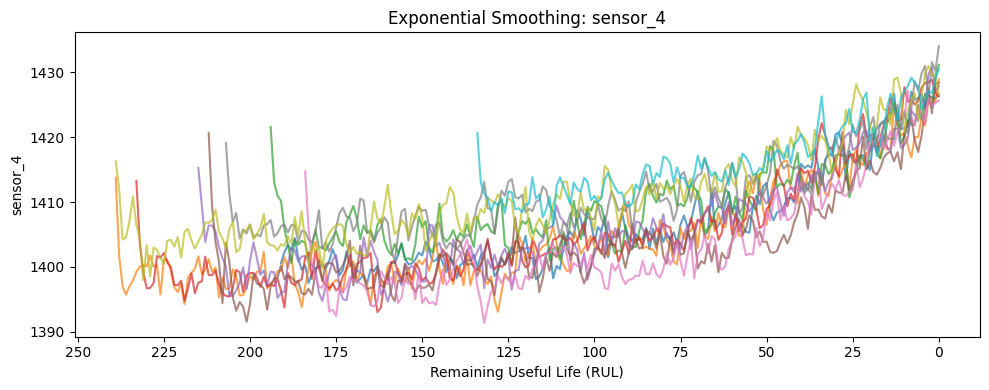

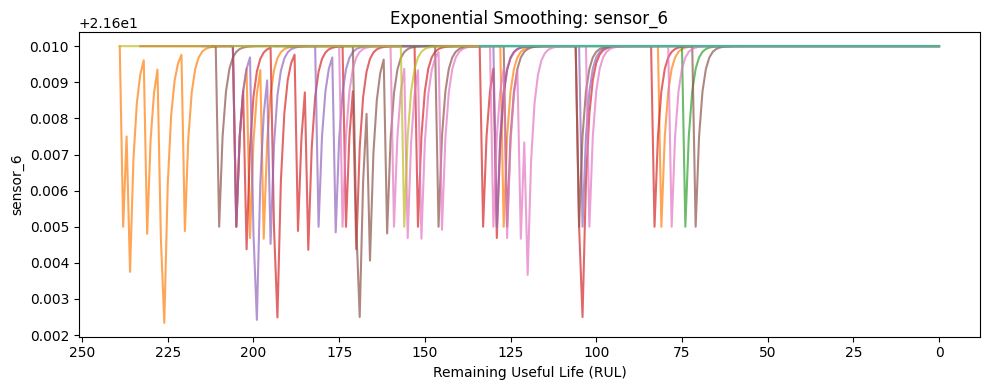

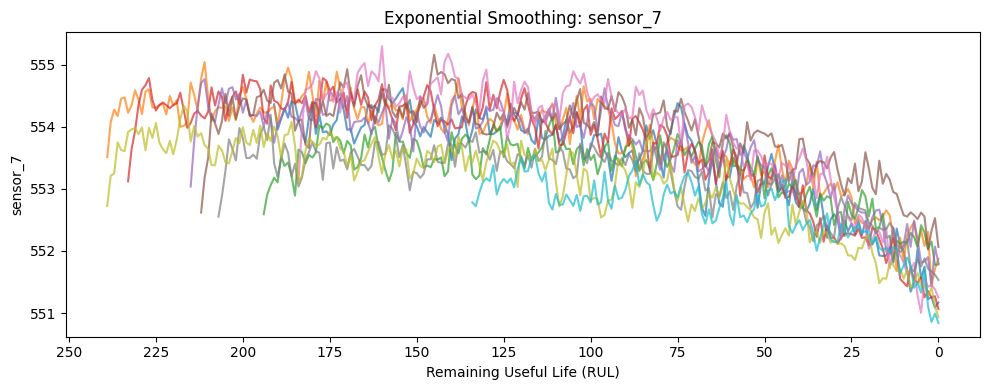

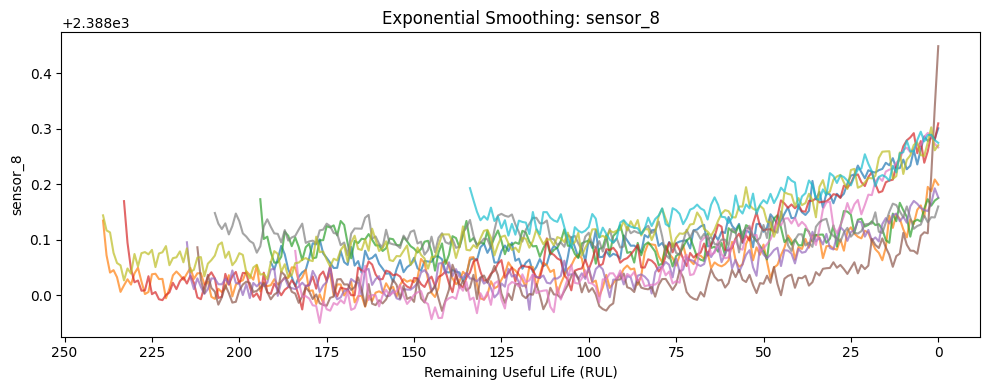

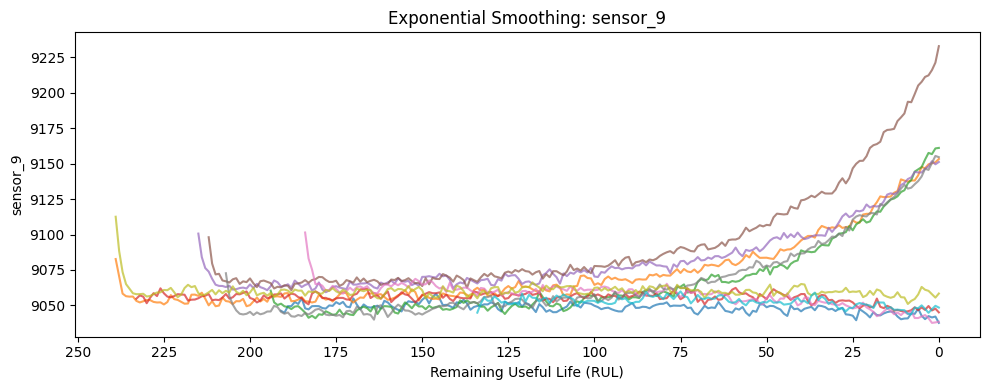

In [125]:
plot_sensors(smoothed_df, plot_type="Exponential Smoothing")